# Noise Model Diagnostics: Residuals Standard Deviation and Magnitude

This example introduces two noise model diagnostics which are useful for studying the variance in time series noise.

The general procedure we follow in this notebook is to start by performing a fit assuming an IID noise process. Next, we generate the diagnostic plots from the IID residuals, and see if they suggest that a more complex noise process is appropriate.

The two diagnostics demonstrated in this notebook are `pints.residuals_diagnostics.plot_residuals_binned_std` and `pints.residuals_diagnostics.plot_residuals_vs_output`. Both methods can take either a single best fit parameter or an MCMC chain of posterior samples. 

The diagnostic plots in the notebook can be used to study the variance of the residuals. Pints also contains diagnostics for studying correlated noise processes, which are covered in [Evaluating noise models using autocorrelation plots of the residuals](residuals-autocorrelation.ipynb) and [Noise model autocorrelation diagnostic plots](residuals-autocorrelation-diagnostics.ipynb).

## Time series with non-IID noise

First, we generate a time series from the logistic model, and add a noise process whose magnitude varies over time. Specifically we use multiplicative noise, in which the magnitude of the noise terms are proportional to the value of the time series. This noise process is discussed in further detail in [Multiplicative Gaussian noise](../stats/multiplicative-gaussian-errors.ipynb).

We then fit the logistic parameters assuming standard IID noise, which will yield a best fit and corresponding residuals.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Use the toy logistic model
model = toy.LogisticModel(initial_population_size=1500)

real_parameters = [0.000025, 10]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
noise = 50
values = org_values + pints.noise.multiplicative_gaussian(2.0, 0.0001, org_values)

# Set up the problem and run the optimisation 
problem = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem)
boundaries = pints.RectangularBoundaries([0, 0], [1, 1000])
x0 = np.array([0.001, 500])

opt = pints.OptimisationController(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

opt.set_log_to_screen(False)

found_parameters, found_value = opt.run()

print('Score at true solution: ')
print(score(real_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Score at true solution: 
4286042.607290019
Found solution:          True parameters:
 1.62287012577255751e-04     2.50000000000000012e-05
 6.05743183656644888e+01     1.00000000000000000e+01


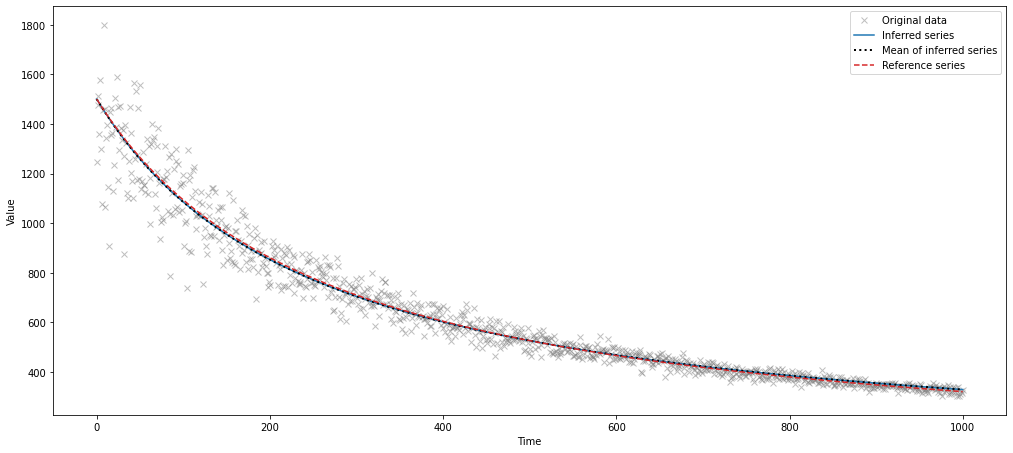

In [2]:
fig, ax = pints.plot.series(np.array([found_parameters]), problem, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

## Binned residuals standard deviation

Having obtained the IID fit, we now generate some diagnostic plots to see whether the IID assumption is valid (since the data was generated using multiplicative noise, we expect to find evidence that IID is not appropriate).

The first diagnostic plot divides the time series into bins, and displays the standard deviation of the residuals calculated within each bin over time. This function is available from Pints using `pints.residuals_diagnostics.plot_residuals_binned_std`. 

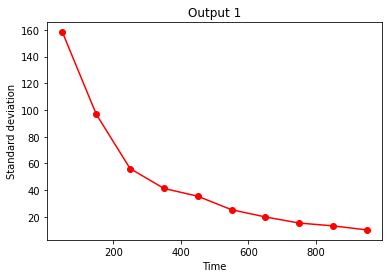

In [3]:
from pints.residuals_diagnostics import plot_residuals_binned_std

fig = plot_residuals_binned_std(
    np.array([found_parameters]),
    problem,
    n_bins=10
)

plt.show()

This plot shows the a steady decrease in the residuals variance over time, suggesting (correctly) that the noise is not actually IID.

## Residuals vs output

Another diagnostic plot which helps to analyse the residuals is available in Pints using the `plot_residuals_vs_output` function in `pints.residuals_diagnostics`. This plot compares the magnitude of the residuals to the values of the solution.

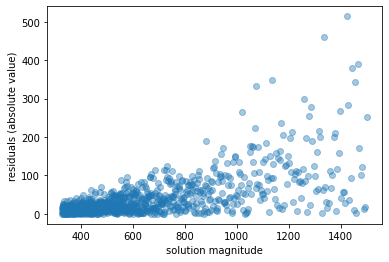

In [4]:
from pints.residuals_diagnostics import plot_residuals_vs_output

fig = plot_residuals_vs_output(
    np.array([found_parameters]),
    problem
)

plt.show()

This plot shows that as the solution magnitude increases, so does the magnitude of the residuals.

Taken together, the two diagnostic plots in this notebook provide good evidence that the noise is not IID, and a multiplicative noise process would be a better choice for another round of optimisation or MCMC inference.